In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:56643")
client

Client Scheduler: tcp://127.0.0.1:56643 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


## Dask dataframes

Just like numpy arrays, Dask implements an equivalent of the Pandas dataframe. Let's briefly remember what a dataframe is by loading some tabular data:

In [2]:
import pandas as pd

In [3]:
births = pd.read_csv('../Data/Birthdays.csv')


In [3]:
births

,Unnamed: 0,state,year,month,day,date,wday,births
0,1,AK,1969,1,1,1969-01-01,Wed,14
1,2,AL,1969,1,1,1969-01-01,Wed,174
2,3,AR,1969,1,1,1969-01-01,Wed,78
3,4,AZ,1969,1,1,1969-01-01,Wed,84
4,5,CA,1969,1,1,1969-01-01,Wed,824
...,...,...,...,...,...,...,...,...
372859,372860,VT,1988,12,31,1988-12-31,Sat,21
372860,372861,WA,1988,12,31,1988-12-31,Sat,157
372861,372862,WI,1988,12,31,1988-12-31,Sat,167
372862,372863,WV,1988,12,31,1988-12-31,Sat,45


A dataframe is a table where each line represents an observation and that can contain numerical values or categorical values (it can contain lists or other complex objects, but rather shouldn't). Each line has an index that can be used to recover that line:

In [4]:
births.loc[0]

Unnamed: 0             1
state                 AK
year                1969
month                  1
day                    1
date          1969-01-01
wday                 Wed
births                14
Name: 0, dtype: object

One can recover each variable either for a specific index:

In [5]:
births.loc[0].state

'AK'

or for the entire dataframe:

In [6]:
births.state

0         AK
1         AL
2         AR
3         AZ
4         CA
          ..
372859    VT
372860    WA
372861    WI
372862    WV
372863    WY
Name: state, Length: 372864, dtype: object

Dataframes also support numpy-like indexing:

In [7]:
births.state == 'AK'

0          True
1         False
2         False
3         False
4         False
          ...  
372859    False
372860    False
372861    False
372862    False
372863    False
Name: state, Length: 372864, dtype: bool

In [8]:
births[births.state == 'AK']

,Unnamed: 0,state,year,month,day,date,wday,births
0,1,AK,1969,1,1,1969-01-01,Wed,14
51,52,AK,1969,1,2,1969-01-02,Thurs,20
102,103,AK,1969,1,3,1969-01-03,Fri,20
153,154,AK,1969,1,4,1969-01-04,Sat,16
204,205,AK,1969,1,5,1969-01-05,Sun,18
...,...,...,...,...,...,...,...,...
372609,372610,AK,1988,12,27,1988-12-27,Tues,38
372660,372661,AK,1988,12,28,1988-12-28,Wed,40
372711,372712,AK,1988,12,29,1988-12-29,Thurs,31
372762,372763,AK,1988,12,30,1988-12-30,Fri,28


In [ ]:
births.mean()

Pandas is a huge library that offers all necessary tools for advanced data science and is used in many other packages such as the plotting library seaborn or the machine learning packages scikit-learn (you can learn a bit more about Pandas e.g. [here](https://github.com/guiwitz/Pandas_course).

## Import as dask-dataframe

We import now the same csv file, but now as a dask-dataframe and not a pandas-dataframe:

In [4]:
from dask import dataframe as dd

In [5]:
births_da = dd.read_csv('../Data/Birthdays.csv')

In [8]:
len(births_da.compute())

372864

In [6]:
births_da

,Unnamed: 0,state,year,month,day,date,wday,births
npartitions=1,,,,,,,,
,int64,object,int64,int64,int64,object,object,int64
,...,...,...,...,...,...,...,...


Again, we see that there are no actual data there. All Dask did was to read the first lines to figure out the columns and types. If we want to have a clearer idea of the file content we can use ```head()```:

In [7]:
births_da.head()

,Unnamed: 0,state,year,month,day,date,wday,births
0,1,AK,1969,1,1,1969-01-01,Wed,14
1,2,AL,1969,1,1,1969-01-01,Wed,174
2,3,AR,1969,1,1,1969-01-01,Wed,78
3,4,AZ,1969,1,1,1969-01-01,Wed,84
4,5,CA,1969,1,1,1969-01-01,Wed,824


Now we can now do the same fancy indexing that we did before:

In [8]:
subtable = births_da[births_da.state == 'AK']

and see that there are still no data there. Let's look at the task graph:

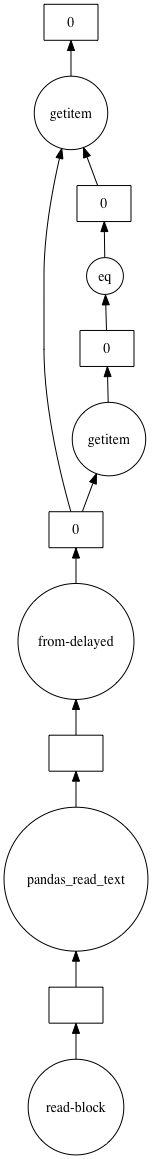

In [9]:
subtable.visualize()

As the file is small, no tasks are parallelized. But we can do this artificially by forcing dask to break the file into smaller chunks:

In [10]:
births_da = dd.read_csv('../Data/Birthdays.csv',
                  blocksize=5e6)


In [12]:
len(births_da.compute())

372864

In [11]:
births_da

,Unnamed: 0,state,year,month,day,date,wday,births
npartitions=4,,,,,,,,
,int64,object,int64,int64,int64,object,object,int64
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


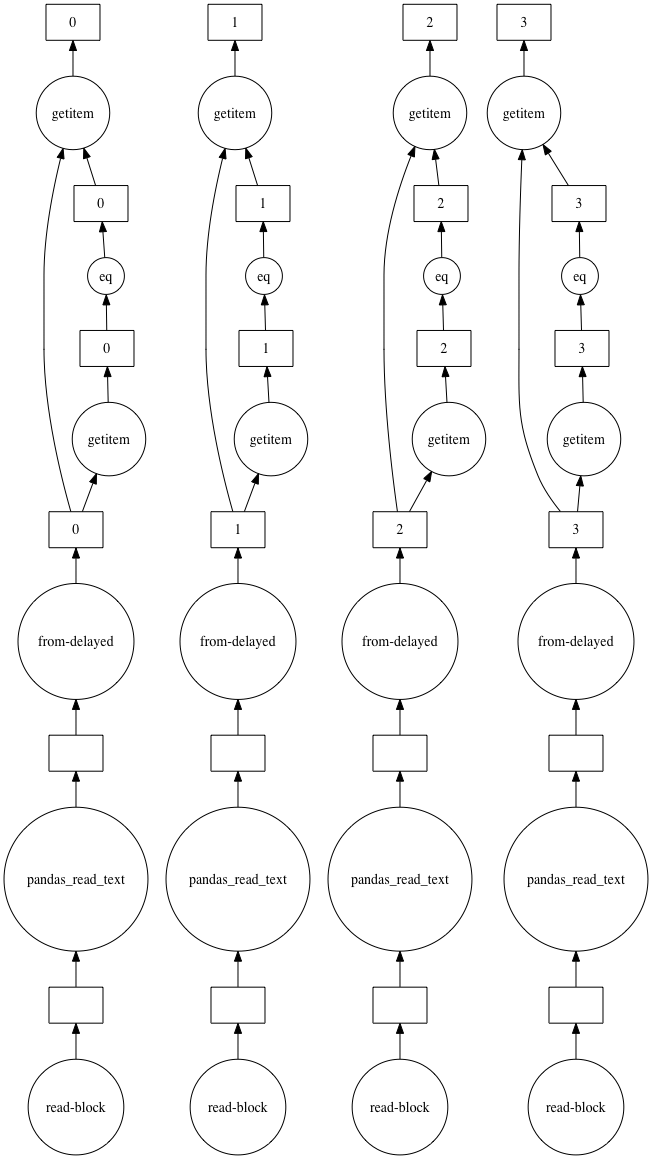

In [13]:
subtable = births_da[births_da.state == 'AK']
subtable.visualize()

## Other classic Pandas applications

One of the main uses of dataframes is the production of statistics, in particular for specific sub-parts of the dataframe through the ```groupby()``` function. These operations are supported by Dask as well:

In [14]:
births_grouped = births_da.groupby('state')

In [16]:
births_group_mean = births_grouped.mean()

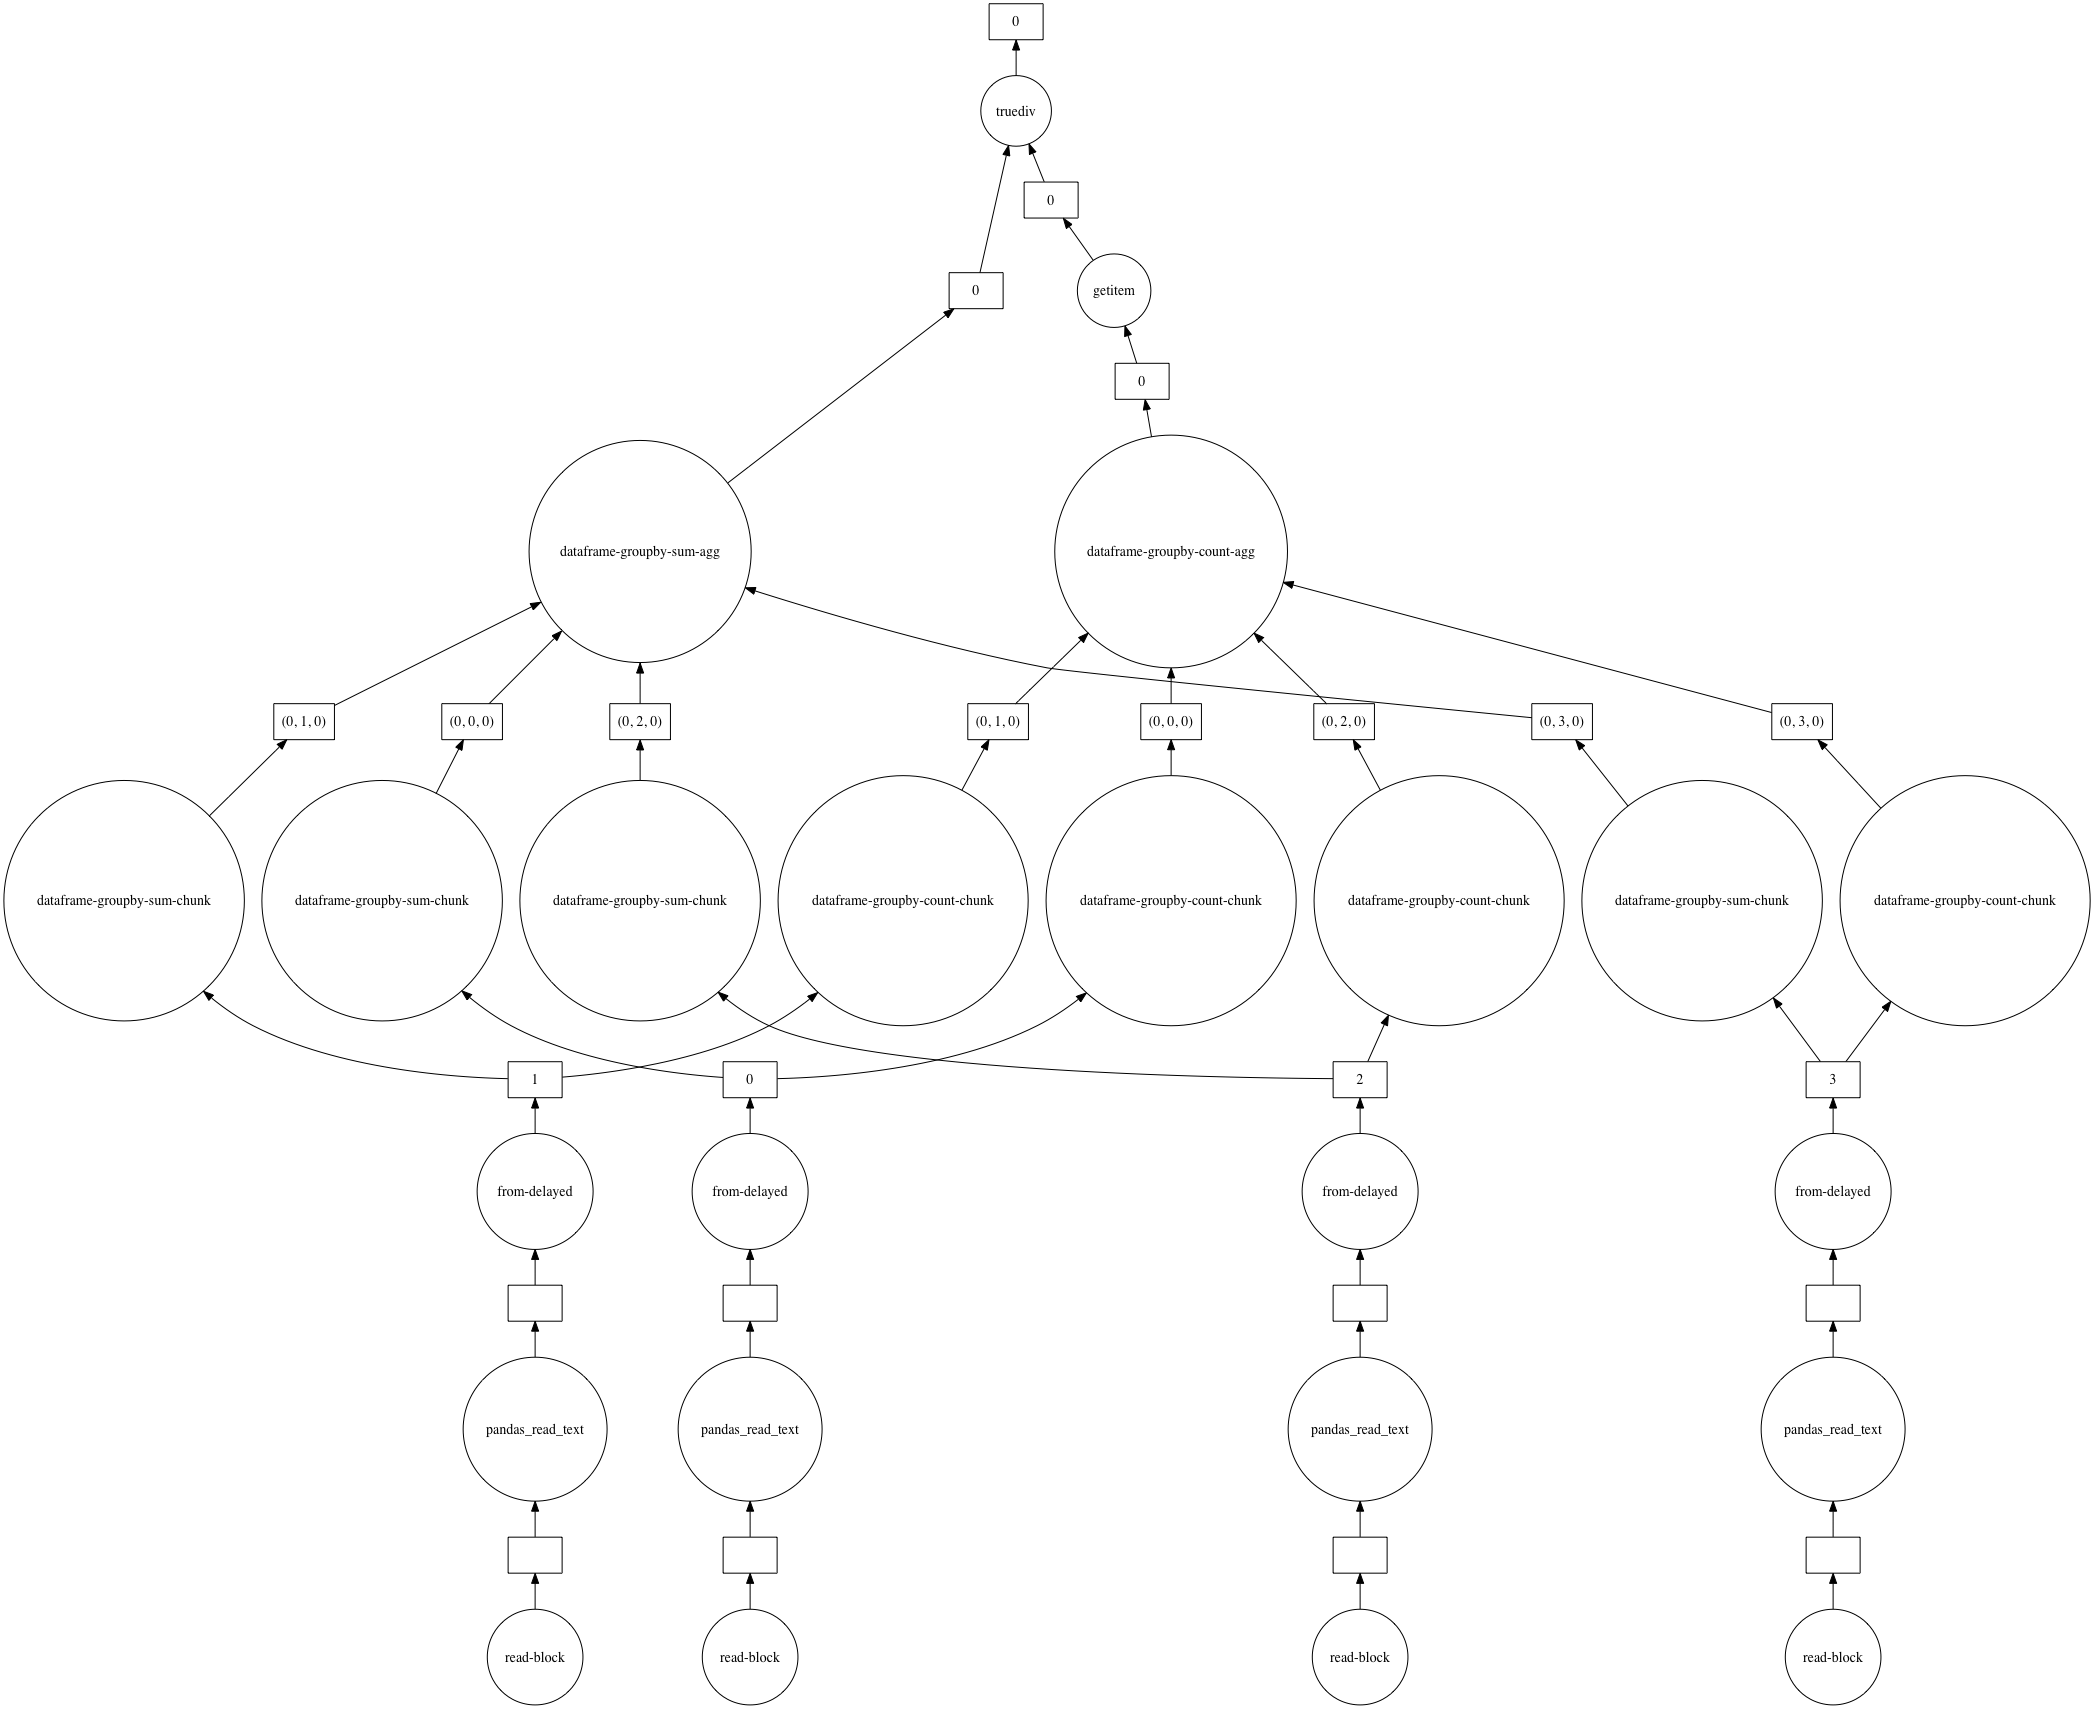

In [17]:
births_group_mean.visualize()

In [18]:
births_group_mean.compute()

,Unnamed: 0,year,month,day,births
state,,,,,
AK,186490.363674,1978.499726,6.523542,15.731727,25.374350
AL,186357.881565,1978.492615,6.522566,15.743846,165.039934
AR,186453.473461,1978.497674,6.522845,15.739808,93.600547
AZ,186436.387141,1978.496854,6.521067,15.739672,129.580575
CA,186215.389352,1978.484778,6.522048,15.770375,1067.956997
CO,186518.550034,1978.501027,6.522930,15.729637,129.552088
CT,186394.528583,1978.494530,6.519967,15.743572,112.737691
DC,186399.759130,1978.494597,6.521953,15.741622,58.195732
DE,186472.827699,1978.498426,6.522650,15.733817,25.825236


In [19]:
births_group_mean.births.nlargest(10).compute()

state
CA    1067.956997
TX     718.072715
NY     702.754534
IL     488.039923
OH     455.844514
PA     444.353615
MI     387.427694
FL     359.148898
NJ     271.122797
GA     251.521739
Name: births, dtype: float64

In [20]:
births_da.state.unique().compute()

0     AK
1     AL
2     AR
3     AZ
4     CA
5     CO
6     CT
7     DC
8     DE
9     FL
10    GA
11    HI
12    IA
13    ID
14    IL
15    IN
16    KS
17    KY
18    LA
19    MA
20    MD
21    ME
22    MI
23    MN
24    MO
25    MS
26    MT
27    NC
28    ND
29    NE
30    NH
31    NJ
32    NM
33    NV
34    NY
35    OH
36    OK
37    OR
38    PA
39    RI
40    SC
41    SD
42    TN
43    TX
44    UT
45    VA
46    VT
47    WA
48    WI
49    WV
50    WY
Name: state, dtype: object

## Larger files

The birth dataset is not very large and dask doesn't really help because it fits in RAM and the overhead of communication betweeen processes is too important.

Let's look at a case where files are larger and/or our dataset is split between multiple files. This dataset is taken from [Zenodo](https://zenodo.org/record/834557#.Xj0fMxP0nOS) and represents an analysis of all edits made to Wikipedia pages from its beginning to 2016.

Data are split among multiple zip files, each containing multiple "largish" (500Mb) CSV files. Let's look at one of them:

In [21]:
filepath = '../Data/wikipedia/20161101-current_content-part1-12-1728.csv'


In [22]:
wikipedia_changes = dd.read_csv(filepath)

In [23]:
wikipedia_changes

,page_id,last_rev_id,token_id,str,origin_rev_id,in,out
npartitions=9,,,,,,,
,int64,int64,int64,object,int64,object,object
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


We see that here Dask decided by default to split the file into 9 partitions becasuse of its size. Let's look at a few lines:

In [24]:
wikipedia_changes.head()

,page_id,last_rev_id,token_id,str,origin_rev_id,in,out
0,12,746687538,1623,see,233194,"[391426, 988138, 6540619, 6551217, 12116305, 1...","[391368, 407005, 6539886, 6540818, 12116304, 1..."
1,12,746687538,1624,also,233194,"[391426, 988138, 6540619, 6551217, 12116305, 1...","[391368, 407005, 6539886, 6540818, 12116304, 1..."
2,12,746687538,3519,.,178538,"[391426, 18309960, 18310083, 47354530, 1328933...","[391381, 871060, 18310026, 18310134, 47417405,..."
3,12,746687538,4507,=,320749,"[83542729, 160471915]","[367665, 83543709]"
4,12,746687538,4508,=,320749,"[83542729, 160471915]","[367665, 83543709]"


The ```page_id``` corresponds to a specific Wikipedia topic, the ```str``` represents a given word that has been added or modified. The ```in``` and ```out``` arrays represent a sequence of events (referenced by an ID) of adding and removal, i.e. the longer the list, the most often this word has been edited.

Word of caution: Dask imports each partition as a separate dataframe, meaning that if the index is a default numeric index, it restarts for each dataframe. In other words, when querying index = 0, we will here get 9 items:

In [25]:
wikipedia_changes.loc[0].compute()

,page_id,last_rev_id,token_id,str,origin_rev_id,in,out
0,12,746687538,1623,see,233194,"[391426, 988138, 6540619, 6551217, 12116305, 1...","[391368, 407005, 6539886, 6540818, 12116304, 1..."
0,593,744804419,36875,by,155262821,"[164630979, 167839234, 183617334, 185043789, 1...","[164630961, 167839008, 183617090, 185043774, 1..."
0,700,746750216,1260,check,619139,"[61773188, 91845565]","[61773072, 91844748]"
0,783,746647937,207927,[,655587695,[707531216],[707530825]
0,864,745162899,76425,|,262349476,"[314394579, 347669693, 348610355, 350408772, 4...","[314394537, 347669682, 348610301, 350408703, 4..."
0,991,744928000,3073,important,18972725,"[77455083, 87982073, 156235181, 156235404, 163...","[77453607, 87981675, 156235168, 156235397, 163..."
0,1175,746229520,33743,]],576608421,[654529644],[654529496]
0,1347,746716698,26536,jpg,163084252,[294293698],[294293671]
0,1537,747000036,174476,</,477994012,"[489689538, 496207384, 511974564, 602763537, 6...","[489689469, 496207260, 497925062, 579792032, 6..."


Hence there is no simple way to "get the first 10 elements of the dataframe". Instead, it's much simpler for example to ask "give me the first 10 elements of page_id = 593":

In [26]:
first_words = wikipedia_changes[wikipedia_changes.page_id==593].loc[0:20].compute()

Let's see what strings we have here:

In [27]:
' '.join(list(first_words.str.values))

'by [[ george ]] , are puppet - animated films which typically use a different version of a puppet for different'

Seems to be [this page](https://www.google.com/search?q=animated+films+which+typically+use+a+different+version+of+a+puppet+for+different&oq=animated+films+which+typically+use+a+different+version+of+a+puppet+for+different&aqs=chrome..69i57.167j0j4&sourceid=chrome&ie=UTF-8).

## Compare Pandas and Dask

Let's see how Pandas and Dask compare on this single "largish" (500Mb) file. We can for example count occurrences of single words. We can use the same functions as in Pandas (```value_counts```) as dasks implements a very close API:

In [28]:
count_str = wikipedia_changes.str.value_counts()

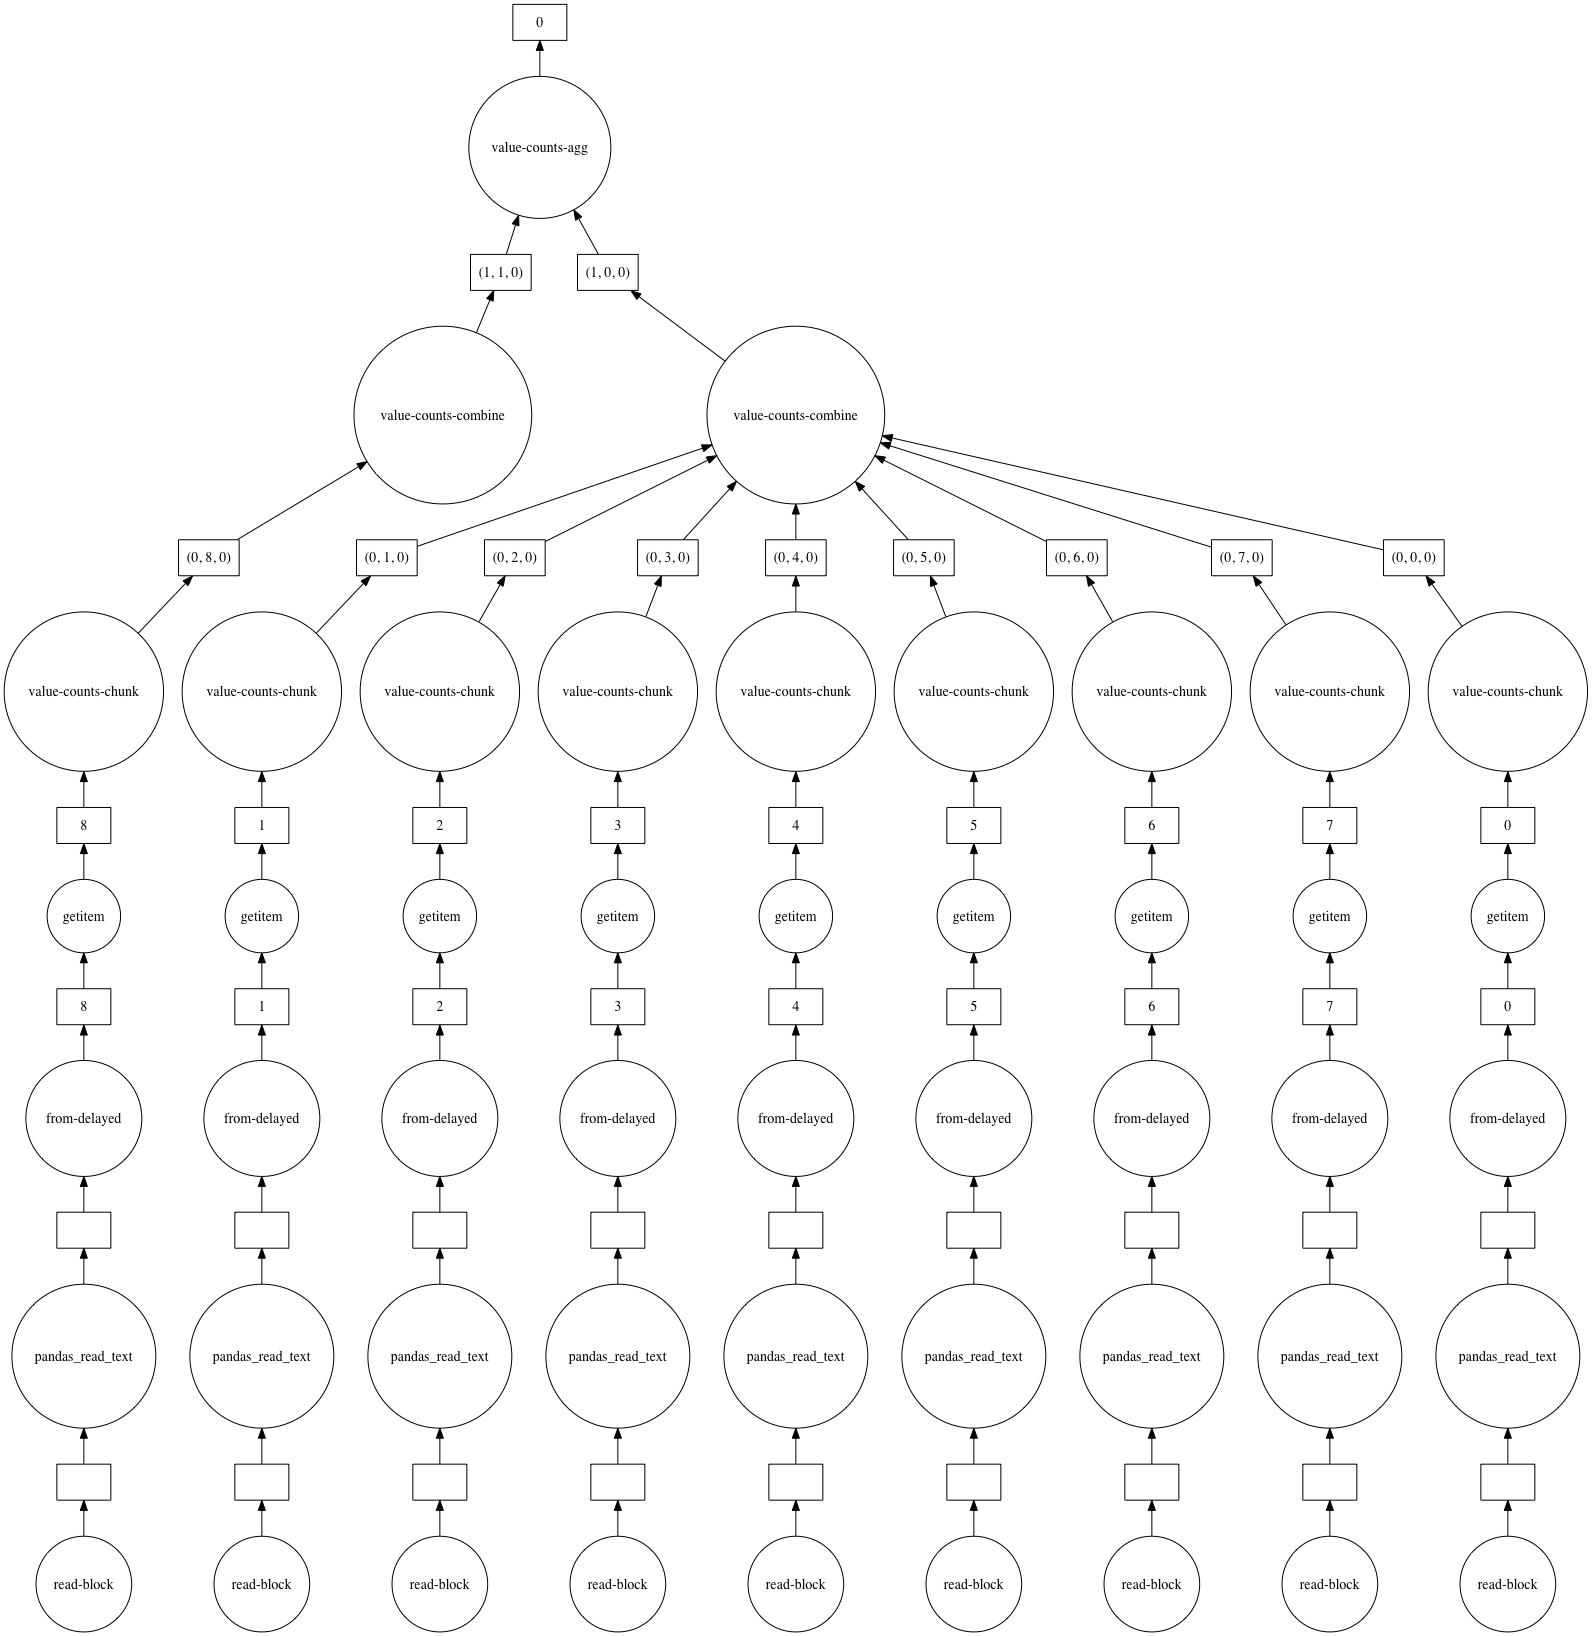

In [29]:
count_str.visualize()

In [30]:
real_count = count_str.compute()

Let's look at the the few most used words or "tokens":

In [31]:
real_count.head(n = 30)

|        256476
=        229648
.        210243
,        181501
the      157474
[[       141926
]]       141926
/        106560
of       105209
-         90254
and       74325
in        59890
>         57475
ref       54172
:         52983
)         47957
(         47930
to        44798
a         44271
}}        41837
{{        41745
*         39386
<         38841
</        28086
;         27291
&         25329
is        21762
as        18853
for       17466
title     16764
Name: str, dtype: int64

Now we compare the performances of Pandas and Dask:

In [32]:
%%time
wikipedia_changes = dd.read_csv(filepath)
count_str = wikipedia_changes.str.value_counts()
real_count = count_str.compute()

CPU times: user 106 ms, sys: 17.2 ms, total: 123 ms
Wall time: 4.57 s


In [33]:
%%time
wiki_pd = pd.read_csv(filepath)
count_str = wiki_pd.str.value_counts()

CPU times: user 4.61 s, sys: 466 ms, total: 5.08 s
Wall time: 5.11 s


We see that Dask doesn't help much in this case.

## Multiple large files

We only looked at a tiny part of the dataset. We will now look at much more of it even though still not at the complete one.

Dask offers the very useful feature of being able to open multiple files as one dask-dataframe by using the wild-card * or generating a file list. For example here, we have multiple CSV files in the folder and we can just say:

In [35]:
wiki_large = dd.read_csv('../Data/wikipedia/2016*.csv')

We see many more partitions, meaning that dask indeed considered all files. If we wanted to import the files with pandas we would have more trouble:

In [36]:
import glob
all_files = glob.glob('../Data/wikipedia/2016*.csv')
#wiki_large_pd = pd.concat((pd.read_csv(f) for f in all_files))

In [37]:
all_files

['../Data/wikipedia/20161101-current_content-part2-1729-3376.csv',
 '../Data/wikipedia/20161101-current_content-part3-3378-4631.csv',
 '../Data/wikipedia/20161101-current_content-part1-12-1728.csv',
 '../Data/wikipedia/20161101-current_content-part4-4633-5902.csv']

Let's time again the same taks as before:

In [38]:
%%time
wiki_large = dd.read_csv('../Data/wikipedia/2016*.csv')
count_str = wiki_large.str.value_counts()
real_count = count_str.compute()

CPU times: user 292 ms, sys: 48.5 ms, total: 340 ms
Wall time: 16.4 s


In [39]:
%%time
all_files = glob.glob('../Data/wikipedia/2016*.csv')
wiki_large_pd = pd.concat([pd.read_csv(f) for f in all_files])
count_str = wiki_large_pd.str.value_counts()

CPU times: user 20.6 s, sys: 2.91 s, total: 23.5 s
Wall time: 24.1 s


## Exercise

1. Create a dask-dataframe from the data in the ```../Data/Chicago_taxi``` folder
2. Try to understand the file by looking at the columns
3. People have multiple ways of paying. Can you find out which category gives on average the largest tip (use groupby) ?